In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout


In [16]:
# Download stock data
stocks = ['RELIANCE.NS', 'TCS.NS']
start_date = '2019-01-01'
end_date = '2024-03-01'

In [19]:
# Fetching data
data = yf.download(stocks, start=start_date, end=end_date)['Close']
data = data.dropna()

# Calculate Moving Averages
data['RELIANCE_MA10'] = data['RELIANCE.NS'].rolling(window=10).mean()
data['RELIANCE_MA50'] = data['RELIANCE.NS'].rolling(window=50).mean()
data['TCS_MA10'] = data['TCS.NS'].rolling(window=10).mean()
data['TCS_MA50'] = data['TCS.NS'].rolling(window=50).mean()
data = data.dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [20]:
# Labeling the target
data['RELIANCE_Target'] = np.where(data['RELIANCE.NS'].shift(-1) > data['RELIANCE.NS'], 1, 0)
data['TCS_Target'] = np.where(data['TCS.NS'].shift(-1) > data['TCS.NS'], 1, 0)
data = data.dropna()

# Normalizing data
scaler = MinMaxScaler()
data[['RELIANCE.NS', 'RELIANCE_MA10', 'RELIANCE_MA50', 'TCS.NS', 'TCS_MA10', 'TCS_MA50']] = scaler.fit_transform(data[['RELIANCE.NS', 'RELIANCE_MA10', 'RELIANCE_MA50', 'TCS.NS', 'TCS_MA10', 'TCS_MA50']])


In [13]:
# Prepare sequences
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)


In [21]:
sequence_length = 20
X_reliance, y_reliance = create_sequences(data[['RELIANCE.NS', 'RELIANCE_MA10', 'RELIANCE_MA50']].values, data['RELIANCE_Target'].values, sequence_length)
X_tcs, y_tcs = create_sequences(data[['TCS.NS', 'TCS_MA10', 'TCS_MA50']].values, data['TCS_Target'].values, sequence_length)


In [22]:
# Oversampling with SMOTE
smote = SMOTE()
X_reliance_res, y_reliance_res = smote.fit_resample(X_reliance.reshape(X_reliance.shape[0], -1), y_reliance)
X_tcs_res, y_tcs_res = smote.fit_resample(X_tcs.reshape(X_tcs.shape[0], -1), y_tcs)

X_reliance_res = X_reliance_res.reshape(X_reliance_res.shape[0], sequence_length, 3)
X_tcs_res = X_tcs_res.reshape(X_tcs_res.shape[0], sequence_length, 3)

In [23]:
# Split data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reliance_res, y_reliance_res, test_size=0.2, random_state=42, shuffle=True)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_tcs_res, y_tcs_res, test_size=0.2, random_state=42, shuffle=True)


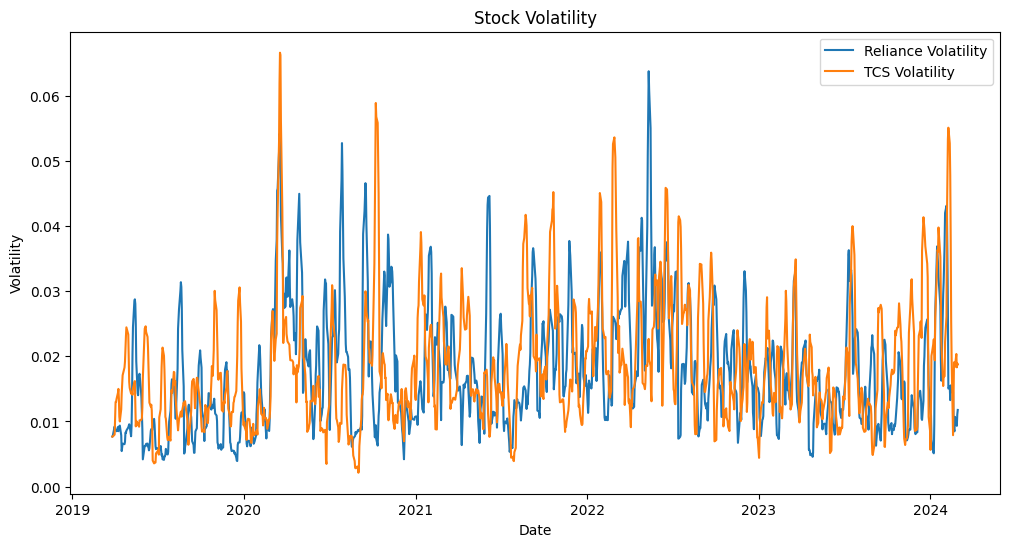

In [25]:
# Stock Volatility Calculation
data['RELIANCE_VOL'] = data['RELIANCE.NS'].rolling(window=10).std()
data['TCS_VOL'] = data['TCS.NS'].rolling(window=10).std()

plt.figure(figsize=(12, 6))
plt.plot(data['RELIANCE_VOL'], label='Reliance Volatility')
plt.plot(data['TCS_VOL'], label='TCS Volatility')
plt.title('Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [24]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = bce(y_true, y_pred) * tf.pow(1.0 - pt, gamma)
        return tf.reduce_mean(alpha * loss)
    return loss

def build_rnn():
    model = Sequential()
    model.add(SimpleRNN(100, activation='tanh', input_shape=(sequence_length, 3), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(SimpleRNN(50, activation='relu', return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=focal_loss(), metrics=['accuracy'])
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_reliance = build_rnn()
model_tcs = build_rnn()

history_r = model_reliance.fit(X_train_r, y_train_r, epochs=100, batch_size=8, validation_split=0.2, callbacks=[early_stop])
history_t = model_tcs.fit(X_train_t, y_train_t, epochs=100, batch_size=8, validation_split=0.2, callbacks=[early_stop])

y_pred_r = (model_reliance.predict(X_test_r) > 0.5).astype(int)
y_pred_t = (model_tcs.predict(X_test_t) > 0.5).astype(int)

print("Reliance Confusion Matrix:")
print(confusion_matrix(y_test_r, y_pred_r))
print(classification_report(y_test_r, y_pred_r))

print("TCS Confusion Matrix:")
print(confusion_matrix(y_test_t, y_pred_t))
print(classification_report(y_test_t, y_pred_t))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5126 - loss: 0.0449 - val_accuracy: 0.5473 - val_loss: 0.0431
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4924 - loss: 0.0455 - val_accuracy: 0.5423 - val_loss: 0.0433
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5187 - loss: 0.0447 - val_accuracy: 0.5423 - val_loss: 0.0432
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5016 - loss: 0.0438 - val_accuracy: 0.5373 - val_loss: 0.0432
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5031 - loss: 0.0441 - val_accuracy: 0.5473 - val_loss: 0.0432
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5042 - loss: 0.0448 - val_accuracy: 0.5274 - val_loss: 0.0432
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4856 - loss: 0.0448 - val_accuracy: 0.5274 - val_loss: 0.0430
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5263 - loss: 0.0432 - 

In [26]:
# Sequence Length Experiment
sequence_lengths = [5, 10, 20]
smote = SMOTE()
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def run_experiment(seq_length):
    X_reliance, y_reliance = create_sequences(data[['RELIANCE.NS', 'RELIANCE_MA10', 'RELIANCE_MA50']].values, data['RELIANCE_Target'].values, seq_length)
    X_tcs, y_tcs = create_sequences(data[['TCS.NS', 'TCS_MA10', 'TCS_MA50']].values, data['TCS_Target'].values, seq_length)

    # Reshape for SMOTE
    X_reliance_res, y_reliance_res = smote.fit_resample(X_reliance.reshape(X_reliance.shape[0], -1), y_reliance)
    X_tcs_res, y_tcs_res = smote.fit_resample(X_tcs.reshape(X_tcs.shape[0], -1), y_tcs)

    X_reliance_res = X_reliance_res.reshape(X_reliance_res.shape[0], seq_length, 3)
    X_tcs_res = X_tcs_res.reshape(X_tcs_res.shape[0], seq_length, 3)

    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reliance_res, y_reliance_res, test_size=0.2, random_state=42)
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_tcs_res, y_tcs_res, test_size=0.2, random_state=42)

    model_r = build_rnn()
    model_t = build_rnn()

    history_r = model_r.fit(X_train_r, y_train_r, epochs=100, batch_size=8, validation_split=0.2, callbacks=[early_stop])
    history_t = model_t.fit(X_train_t, y_train_t, epochs=100, batch_size=8, validation_split=0.2, callbacks=[early_stop])

    y_pred_r = (model_r.predict(X_test_r) > 0.5).astype(int)
    y_pred_t = (model_t.predict(X_test_t) > 0.5).astype(int)

    print(f"\n=== Sequence Length {seq_length} ===")
    print("Reliance Confusion Matrix:")
    print(confusion_matrix(y_test_r, y_pred_r))
    print(classification_report(y_test_r, y_pred_r))

    print("TCS Confusion Matrix:")
    print(confusion_matrix(y_test_t, y_pred_t))
    print(classification_report(y_test_t, y_pred_t))

for seq in sequence_lengths:
    run_experiment(seq)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5092 - loss: 0.0463 - val_accuracy: 0.4926 - val_loss: 0.0435
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4842 - loss: 0.0448 - val_accuracy: 0.4877 - val_loss: 0.0443
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5013 - loss: 0.0448 - val_accuracy: 0.4877 - val_loss: 0.0434
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4912 - loss: 0.0447 - val_accuracy: 0.4877 - val_loss: 0.0446
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5383 - loss: 0.0440 - val_accuracy: 0.5074 - val_loss: 0.0434
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5137 - loss: 0.0430 - val_accuracy: 0.4877 - val_loss: 0.0434
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4783 - loss: 0.0442 - val_accuracy: 0.4877 - val_loss: 0.0435
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5036 - loss: 0.0440 - val_

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



=== Sequence Length 5 ===
Reliance Confusion Matrix:
[[63 72]
 [58 60]]
              precision    recall  f1-score   support

           0       0.52      0.47      0.49       135
           1       0.45      0.51      0.48       118

    accuracy                           0.49       253
   macro avg       0.49      0.49      0.49       253
weighted avg       0.49      0.49      0.49       253

TCS Confusion Matrix:
[[101  25]
 [108  22]]
              precision    recall  f1-score   support

           0       0.48      0.80      0.60       126
           1       0.47      0.17      0.25       130

    accuracy                           0.48       256
   macro avg       0.48      0.49      0.43       256
weighted avg       0.48      0.48      0.42       256

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4863 - loss: 0.0486 - val_accuracy: 0.5099 - val_loss: 0.0444
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4843 - loss: 0.0447 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5182 - loss: 0.0453 - val_accuracy: 0.5323 - val_loss: 0.0433
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5109 - loss: 0.0453 - val_accuracy: 0.4577 - val_loss: 0.0436
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4994 - loss: 0.0464 - val_accuracy: 0.5075 - val_loss: 0.0434
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4880 - loss: 0.0450 - val_accuracy: 0.5025 - val_loss: 0.0434
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5287 - loss: 0.0444 - val_accuracy: 0.5323 - val_loss: 0.0430
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4688 - loss: 0.0452 - val_accuracy: 0.5423 - val_loss: 0.0432
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4998 - loss: 0.0443 - val_accuracy: 0.4975 - val_loss: 0.0436
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5213 - loss: 0.0441 - val_accuracy

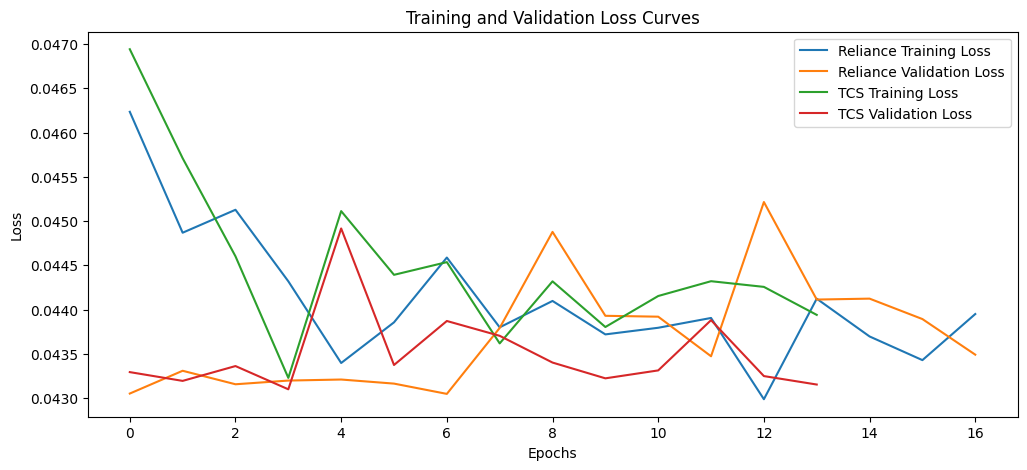

In [27]:
accuracies = {'Sequence Length': [], 'Reliance Accuracy': [], 'TCS Accuracy': []}

for seq in sequence_lengths:
    accuracies['Sequence Length'].append(seq)
    accuracies['Reliance Accuracy'].append(history_r.history['val_accuracy'][-1])
    accuracies['TCS Accuracy'].append(history_t.history['val_accuracy'][-1])

accuracies_df = pd.DataFrame(accuracies)
accuracies_df.plot(x='Sequence Length', y=['Reliance Accuracy', 'TCS Accuracy'], kind='bar', figsize=(10, 6))
plt.title('Model Accuracy Across Sequence Lengths')
plt.ylabel('Accuracy')
plt.show()
